In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from datasets import get_dataset

IMG_SIZE = 224
DATASET_NAME = "celeba"
DATASET_DIRS = ["/Users/erogullari/datasets/"]      # change to the directory containing CelebA

dataset = get_dataset(DATASET_NAME)(data_paths=DATASET_DIRS,
                                    normalize_data=True,
                                    image_size=IMG_SIZE)

len(dataset)

Using subset


20260

In [3]:
# Concepts present
concepts = list(dataset.sample_ids_by_concept.keys())
print(f"Number of concepts present: {len(concepts)}")
print("Some examples:")
for attr in concepts[:5]:
    print(f"    {attr} --> {len(dataset.sample_ids_by_concept[attr])}")

Number of concepts present: 40
Some examples:
    5_o_Clock_Shadow --> 2289
    Arched_Eyebrows --> 5491
    Attractive --> 10391
    Bags_Under_Eyes --> 4134
    Bald --> 446


In [4]:
for i, c in enumerate(concepts):
    print(f"{i:3d}. {c:20s}")

  0. 5_o_Clock_Shadow    
  1. Arched_Eyebrows     
  2. Attractive          
  3. Bags_Under_Eyes     
  4. Bald                
  5. Bangs               
  6. Big_Lips            
  7. Big_Nose            
  8. Black_Hair          
  9. Blond_Hair          
 10. Blurry              
 11. Brown_Hair          
 12. Bushy_Eyebrows      
 13. Chubby              
 14. Double_Chin         
 15. Eyeglasses          
 16. Goatee              
 17. Gray_Hair           
 18. Heavy_Makeup        
 19. High_Cheekbones     
 20. Male                
 21. Mouth_Slightly_Open 
 22. Mustache            
 23. Narrow_Eyes         
 24. No_Beard            
 25. Oval_Face           
 26. Pale_Skin           
 27. Pointy_Nose         
 28. Receding_Hairline   
 29. Rosy_Cheeks         
 30. Sideburns           
 31. Smiling             
 32. Straight_Hair       
 33. Wavy_Hair           
 34. Wearing_Earrings    
 35. Wearing_Hat         
 36. Wearing_Lipstick    
 37. Wearing_Necklace    
 38. Wearing

In [5]:
# Binary labels tensor
labels = torch.tensor(dataset.attributes.to_numpy(), dtype=torch.float32)
labels.shape

torch.Size([20260, 40])

In [6]:
from models import get_fn_model_loader

MODEL_NAME = "vgg16"
N_CLASSES = 2
CHECKPT_PATH = "checkpoints/checkpoint_vgg16_celeba.pth"
device = 'cpu'      # Change to your device

model = get_fn_model_loader(model_name=MODEL_NAME)(n_class=N_CLASSES, ckpt_path=CHECKPT_PATH).to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
def get_features(batch, layer_names, attribution, cav_mode="max", device="cpu"):
    batch.requires_grad = True
    dummy_cond = [{"y": 0} for _ in range(len(batch))]
    attr = attribution(batch.to(device), dummy_cond, record_layer=layer_names)
    if cav_mode == "full":
        activations = attr.activations
    if cav_mode == "max":
        activations = {}
        for layer_name in layer_names:
            activations[layer_name] = attr.activations[layer_name].flatten(start_dim=2).max(2)[0]
    return activations

In [8]:
from crp.attribution import CondAttribution
from torch.utils.data import DataLoader

LAYER_IDS = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]  # VGG16 Convolutional layers
LAYERS = [f"features.{layer_id}" for layer_id in LAYER_IDS]

# File path to save/load latent variables
folder_path = "variables/latents_celeba_vgg16"


if False:
    attribution = CondAttribution(model)
    # Check if the latent variables have been precomputed and saved
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)

    # Compute latent embeddings
    BATCH_SIZE = 16
    CAV_MODE = "max"
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    x_latent_all = {}
    for x, y in tqdm(dataloader):
        activations = get_features(x, LAYERS, attribution, CAV_MODE, device='mps')
        for layer_name, x_latent in activations.items():
            if layer_name not in x_latent_all:
                x_latent_all[layer_name] = []
            x_latent = x_latent.detach().cpu()
            x_latent_all[layer_name].append(x_latent)

    # Concatenate and save all latent variables for each layer
    for layer_name in x_latent_all:
        x_latent_all[layer_name] = torch.cat(x_latent_all[layer_name], dim=0)
        latent_file_path = os.path.join(folder_path, f"{layer_name}.pth")
        if not os.path.exists(latent_file_path):
            os.makedirs(os.path.dirname(latent_file_path), exist_ok=True)
        torch.save(x_latent_all[layer_name], latent_file_path)
        print(f"Computed and saved latent variables for {layer_name} to {latent_file_path} (shape: {x_latent_all[layer_name].shape})")

In [9]:
from utils.cav import compute_all_cavs

folder_path = "variables/latents_celeba_vgg16"
cavs_original = {}

size = len(dataset)
shuffled_ids = torch.randperm(size)
train_ids = shuffled_ids[:int(0.8 * size)]
test_ids = shuffled_ids[int(0.8 * size):]

# Baseline CAVs
for layer in LAYERS:
    latent_file_path = os.path.join(folder_path, f"{layer}.pth")
    if os.path.exists(latent_file_path):
        latents_train = torch.load(latent_file_path)[train_ids]
        labels_train = labels[train_ids]
    else:
        raise FileNotFoundError(f"Latent file for {layer} not found at {latent_file_path}")
    
    cavs_original[layer] = compute_all_cavs(latents_train, labels_train)
    print(f"Computed CAVs for {layer} with shape: {cavs_original[layer].shape}")

Computed CAVs for features.0 with shape: torch.Size([40, 64])
Computed CAVs for features.2 with shape: torch.Size([40, 64])
Computed CAVs for features.5 with shape: torch.Size([40, 128])
Computed CAVs for features.7 with shape: torch.Size([40, 128])
Computed CAVs for features.10 with shape: torch.Size([40, 256])
Computed CAVs for features.12 with shape: torch.Size([40, 256])
Computed CAVs for features.14 with shape: torch.Size([40, 256])
Computed CAVs for features.17 with shape: torch.Size([40, 512])
Computed CAVs for features.19 with shape: torch.Size([40, 512])
Computed CAVs for features.21 with shape: torch.Size([40, 512])
Computed CAVs for features.24 with shape: torch.Size([40, 512])
Computed CAVs for features.26 with shape: torch.Size([40, 512])
Computed CAVs for features.28 with shape: torch.Size([40, 512])


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/1882352460.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latents_train = torch.load(latent_file_path)

In [10]:
from utils.metrics import get_uniqueness, compute_auc_performance

folder_path = "variables/latents_celeba_vgg16"

uniqueness_vals = {}
auc_vals = {}
for layer in LAYERS:
    latent_file_path = os.path.join(folder_path, f"{layer}.pth")
    if os.path.exists(latent_file_path):
        latents_test = torch.load(latent_file_path, weights_only=True)[test_ids]
        labels_test = labels[test_ids]
    else:
        raise FileNotFoundError(f"Latent file for {layer} not found at {latent_file_path}")
    
    # Compute uniqueness and AUC for each layer
    uniqueness_vals[layer] = get_uniqueness(cavs_original[layer])
    auc_vals[layer] = compute_auc_performance(cavs_original[layer], latents_test, labels_test)
    print(f"Computed uniqueness and AUC for {layer}.")

uniqueness_vals[LAYERS[0]].shape, auc_vals[LAYERS[0]].shape

Computed uniqueness and AUC for features.0.
Computed uniqueness and AUC for features.2.
Computed uniqueness and AUC for features.5.
Computed uniqueness and AUC for features.7.
Computed uniqueness and AUC for features.10.
Computed uniqueness and AUC for features.12.
Computed uniqueness and AUC for features.14.
Computed uniqueness and AUC for features.17.
Computed uniqueness and AUC for features.19.
Computed uniqueness and AUC for features.21.
Computed uniqueness and AUC for features.24.
Computed uniqueness and AUC for features.26.
Computed uniqueness and AUC for features.28.


((40,), (40,))

## Global AUC vs Orthogonality Over Layers

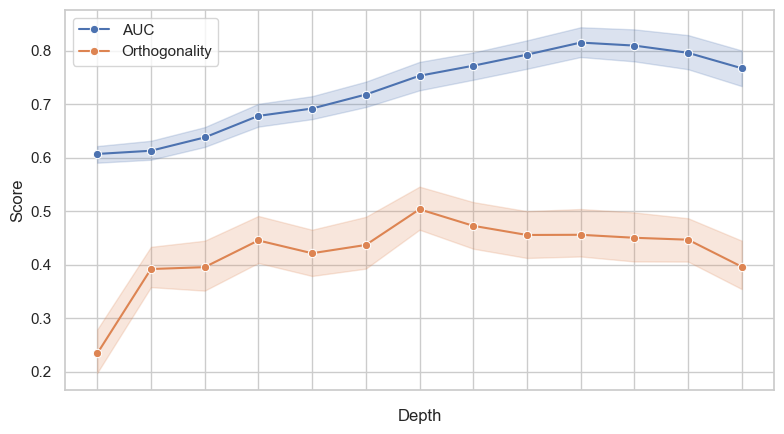

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

records = []
for depth in LAYERS:
    # AUC values for this layer
    for v in np.asarray(auc_vals[depth]).ravel():
        records.append({"depth": depth, "metric": "AUC", "value": float(v)})
    # Orthogonality values for this layer
    for v in np.asarray(uniqueness_vals[depth]).ravel():
        records.append({"depth": depth, "metric": "Orthogonality", "value": float(v)})

df = pd.DataFrame(records)
df["depth"] = pd.Categorical(df["depth"], categories=LAYERS, ordered=True)

plt.figure(figsize=(8, 4.5))
sns.set_theme(style="whitegrid")
sns.lineplot(
    data=df,
    x="depth",
    y="value",
    hue="metric",
    estimator="mean",
    errorbar=("ci", 95),   # seaborn >= 0.12; for older versions use ci=95
    marker="o"
)
plt.xlabel("Depth")
plt.ylabel("Score")
plt.legend(title="")
plt.gca().set_xticklabels([])
plt.tight_layout()
plt.savefig("media/auc_orthogonality_over_layers/global.pdf", format="pdf")
plt.show()

## Individual AUC vs Orthogonality Over Layers

/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_0.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_1.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_2.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_3.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_4.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_5.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_6.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_7.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_8.pdf


/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LAYERS)))
/var/folders/rr/r9c8x9_j5w3dvj0__lq77wlx3315j3/T/ipykernel_86921/3306296092.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(len(LA

Saved media/auc_orthogonality_over_layers/concepts_batch_9.pdf


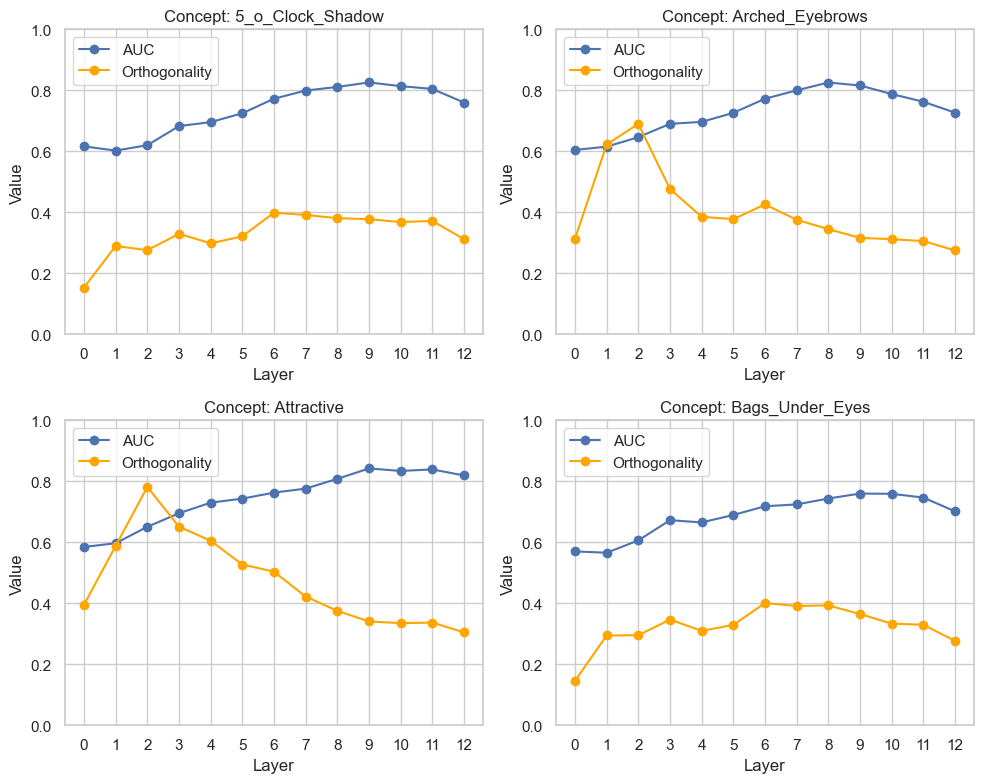

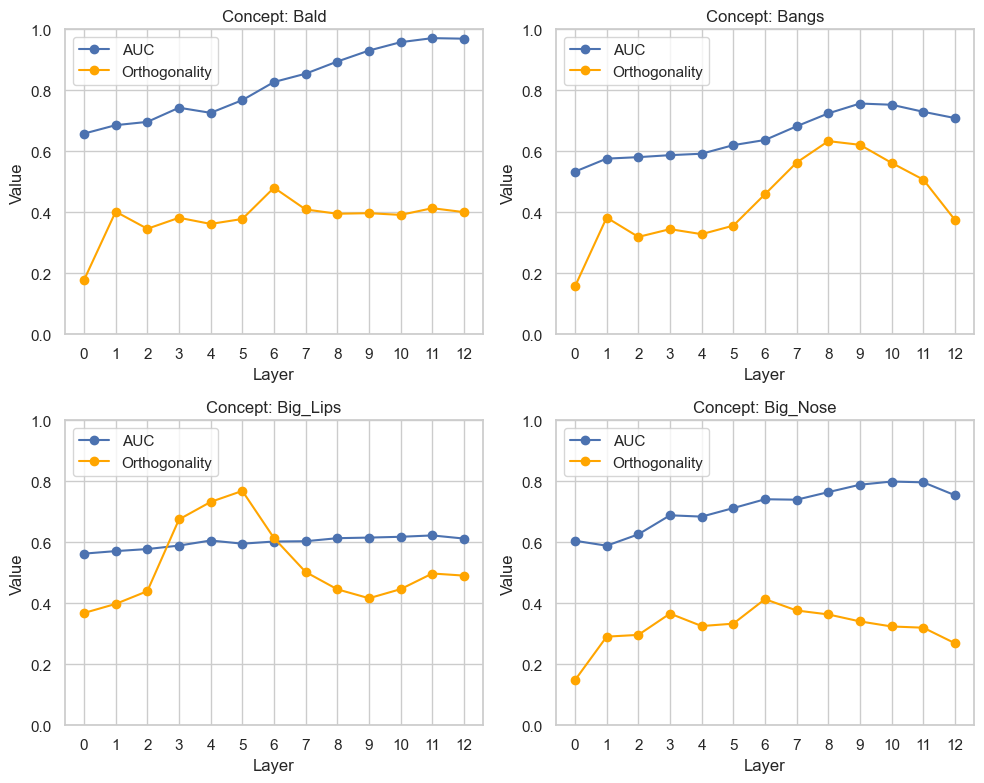

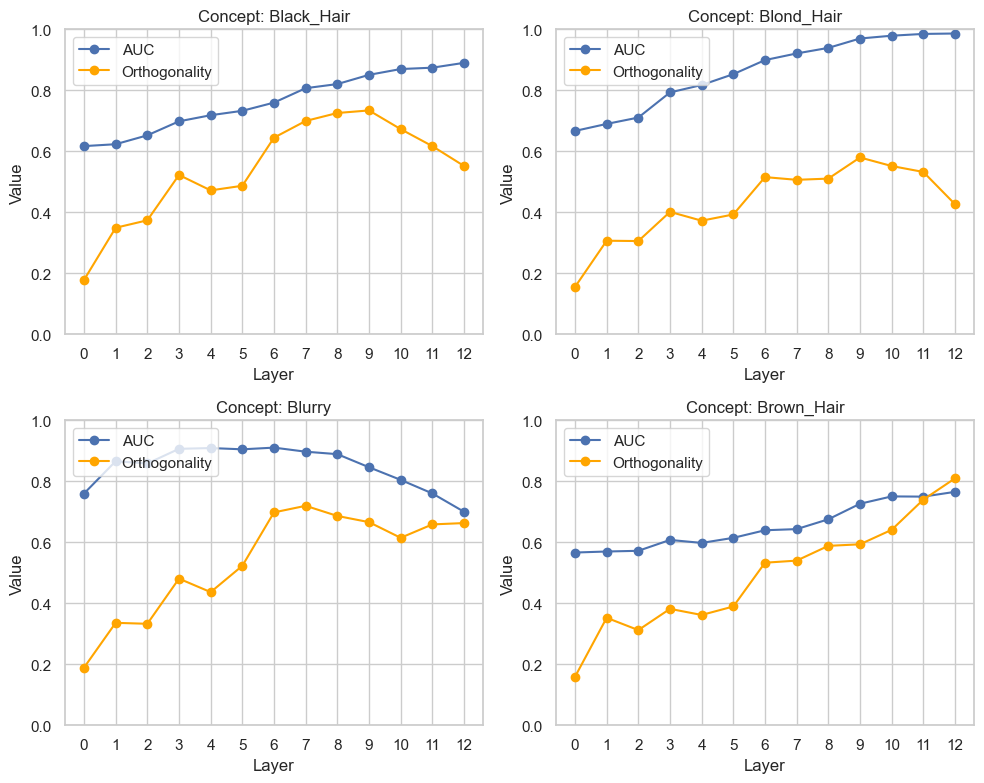

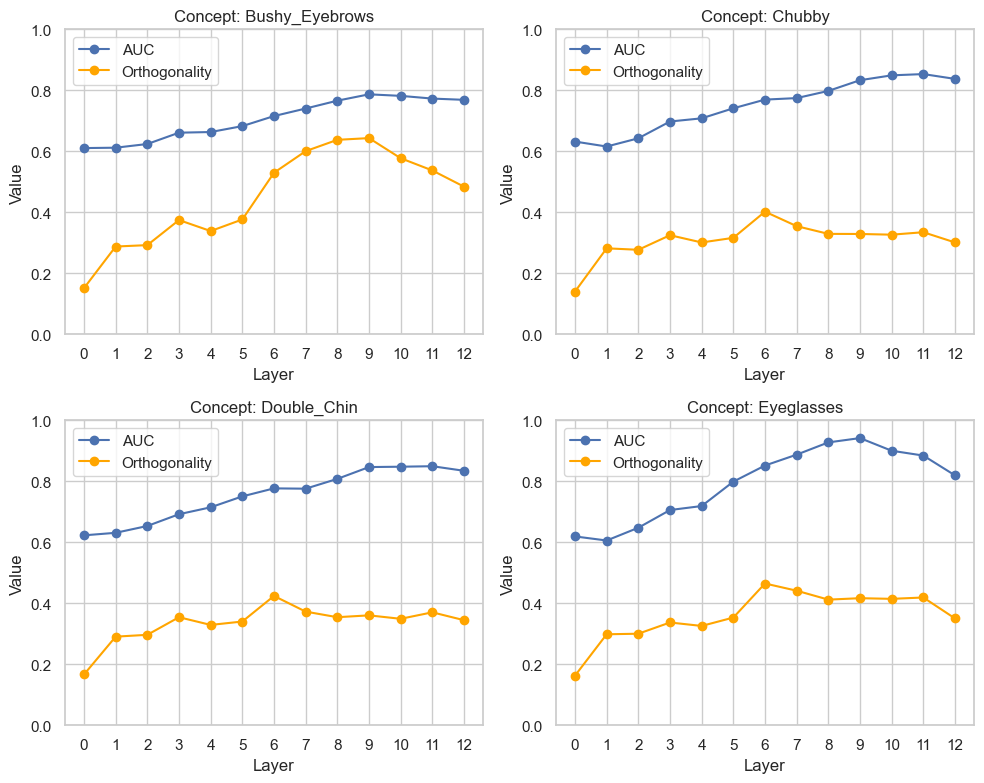

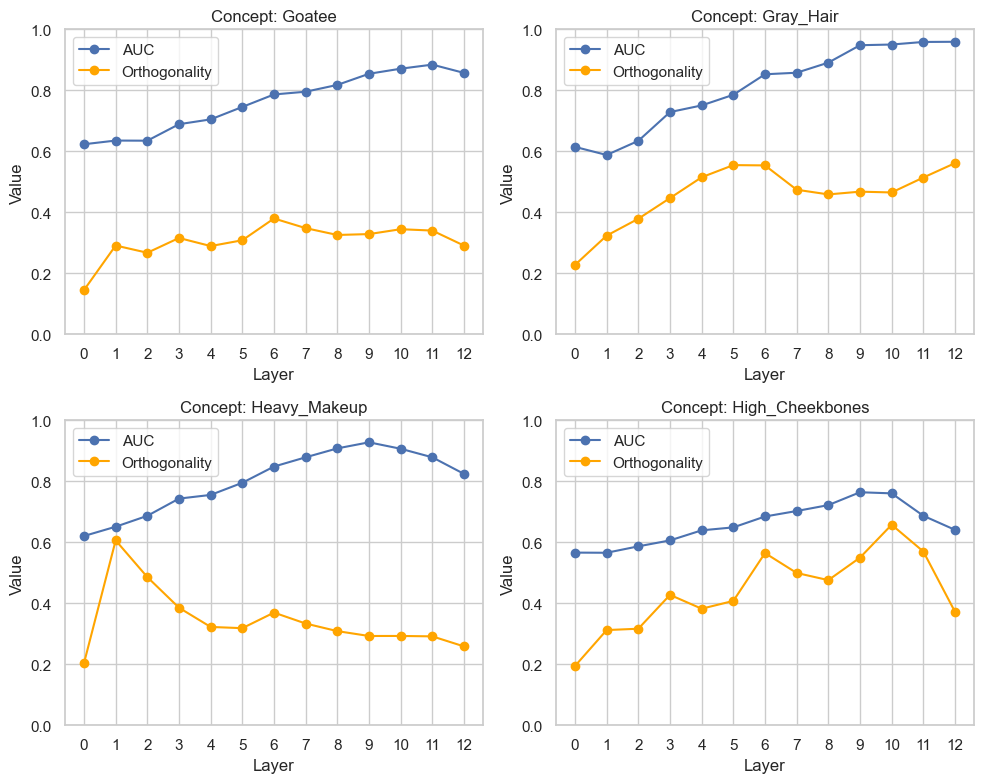

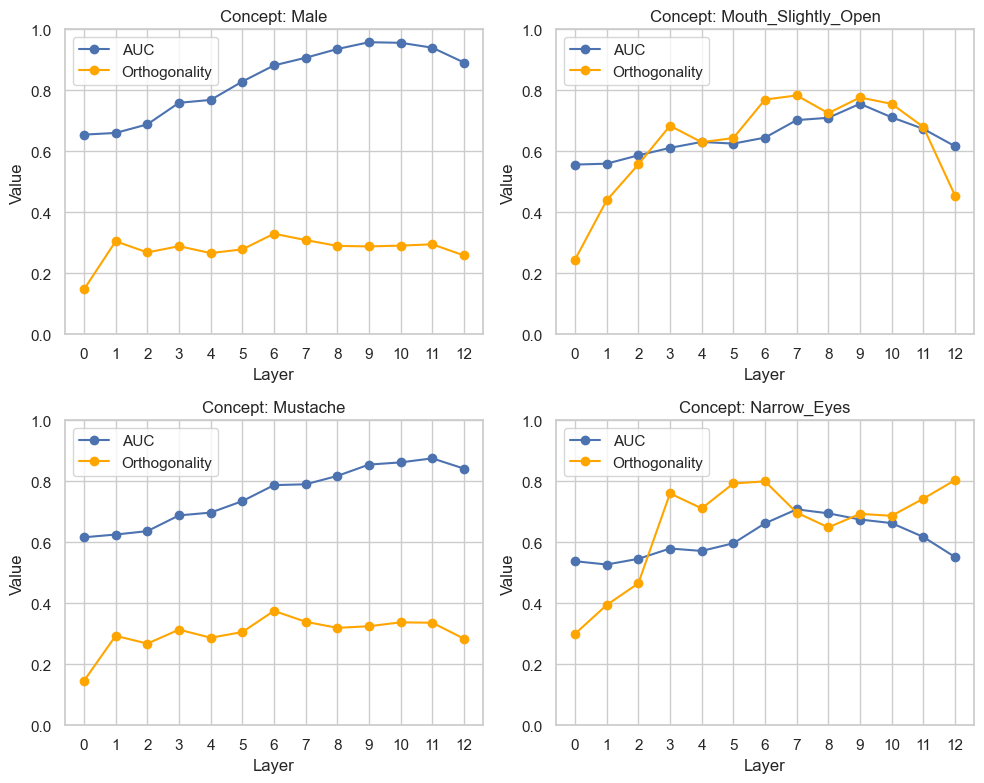

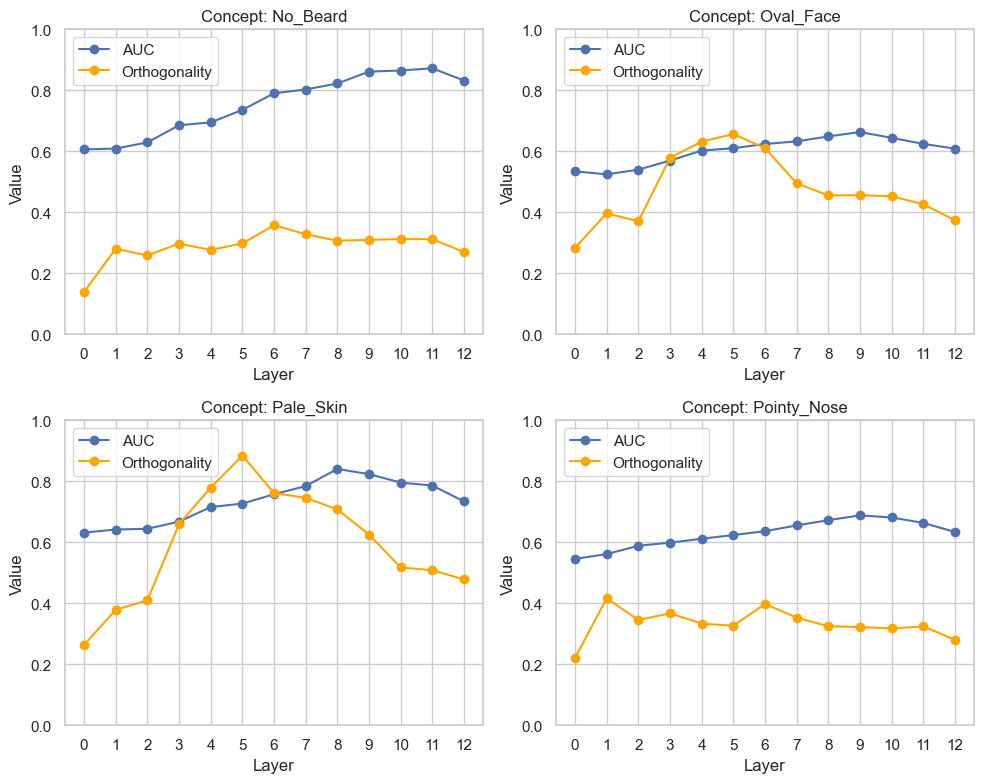

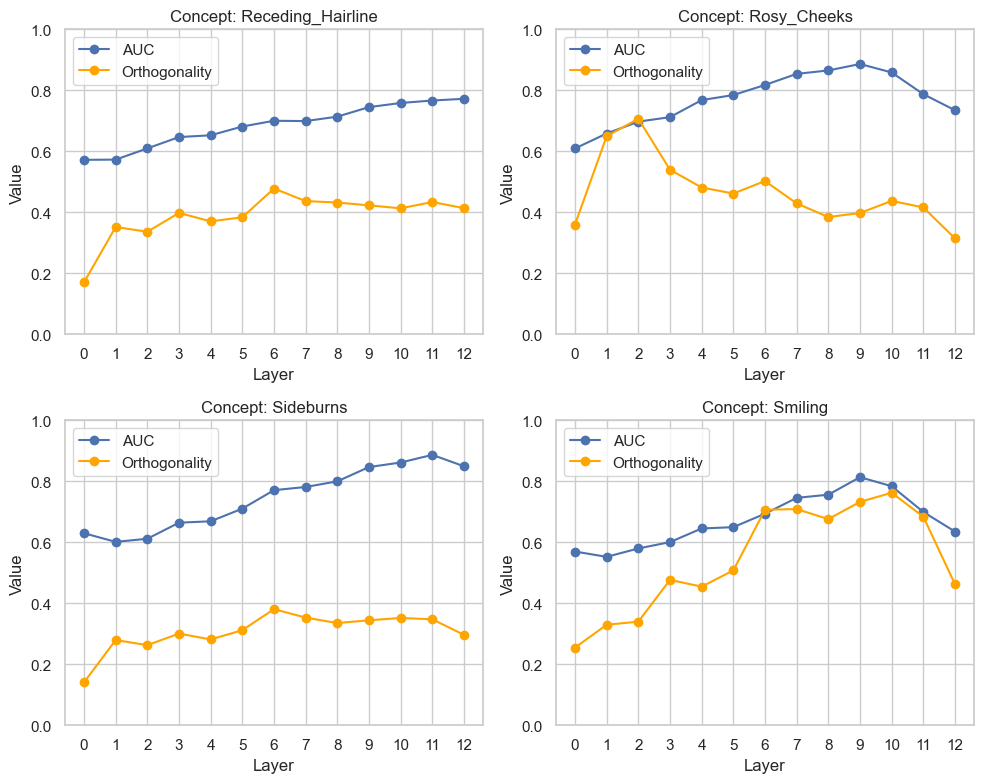

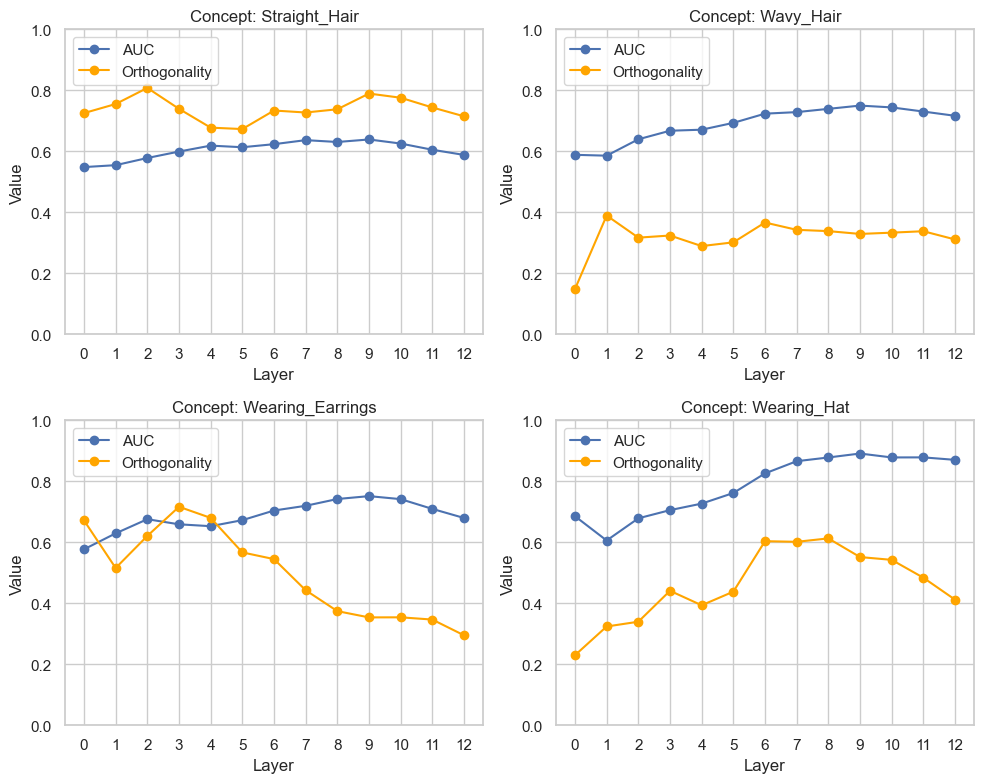

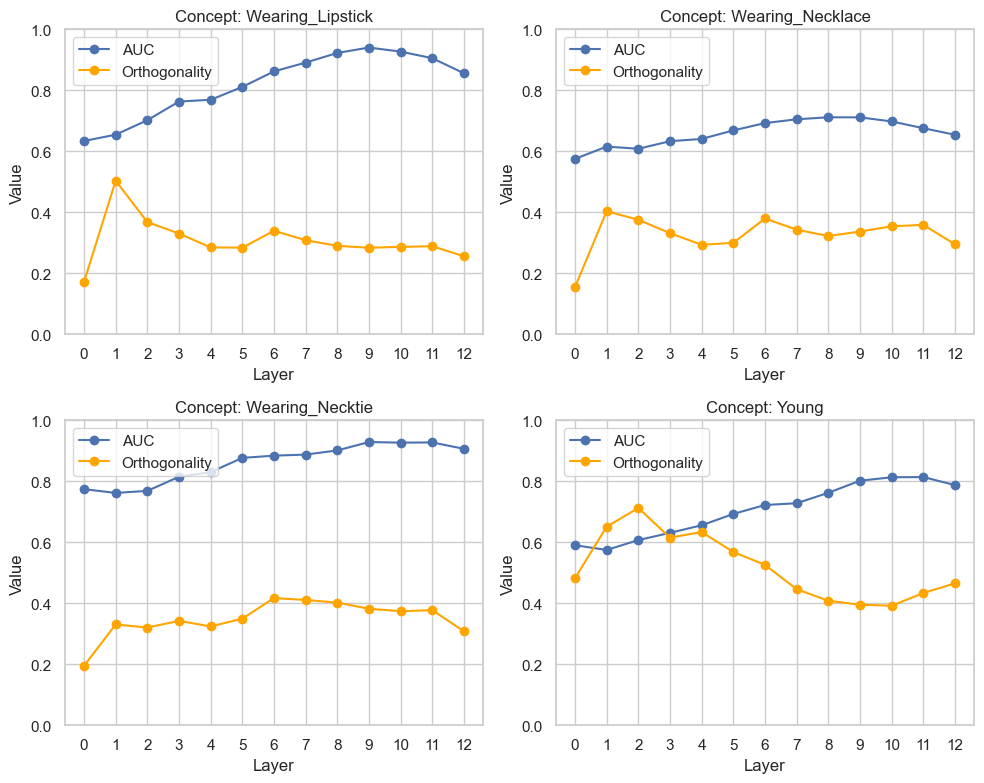

In [13]:
for batch_id in range(10):   # Change range for different batches of concepts
    indices_to_plot = list(range(batch_id*4, batch_id*4 + 4)) 

    # Plot 4 concepts AUC and Orthogonality over all layers on a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    auc_plots = [None] * len(indices_to_plot)
    orthogonality_plots = [None] * len(indices_to_plot)

    for i, idx in enumerate(indices_to_plot):
        auc_plots[i] = [auc_vals[layer][idx] for layer in LAYERS]
        orthogonality_plots[i] = [uniqueness_vals[layer][idx] for layer in LAYERS]

    for idx, ax in enumerate(axes.flatten()):
        concept = concepts[indices_to_plot[idx]]

        # Plot both lines on the same axis
        ax.plot(LAYERS, auc_plots[idx], color='b', marker='o', label='AUC')
        ax.plot(LAYERS, orthogonality_plots[idx], color='orange', marker='o',label='Orthogonality')

        ax.set_title(f'Concept: {concept}')
        ax.set_xlabel('Layer')
        ax.set_ylabel('Value')
        ax.set_ylim(0, 1)  # unify scale
        ax.set_xticklabels(range(len(LAYERS)))

        # Single legend
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig(f"media/auc_orthogonality_over_layers/concepts_batch_{batch_id}.pdf", format="pdf")
    print(f"Saved media/auc_orthogonality_over_layers/concepts_batch_{batch_id}.pdf")

## Grouped AUC vs Orthogonality Over Layers

In [25]:
# Simple (low-level, local, texture/color/accessories)
simple_concepts = [
    4,  # Bald
    5,  # Bangs
    8,  # Black_Hair
    9,  # Blond_Hair
    10, # Blurry
    11, # Brown_Hair
    15, # Eyeglasses
    17, # Gray_Hair
    26, # Pale_Skin
    29, # Rosy_Cheeks
    32, # Straight_Hair
    33, # Wavy_Hair
    34, # Wearing_Earrings
    35, # Wearing_Hat
    36, # Wearing_Lipstick
    37, # Wearing_Necklace
    38  # Wearing_Necktie
]

# Mid-level (part structure, local shape)
mid_concepts = [
    0,  # 5_o_Clock_Shadow
    1,  # Arched_Eyebrows
    3,  # Bags_Under_Eyes
    6,  # Big_Lips
    7,  # Big_Nose
    12, # Bushy_Eyebrows
    14, # Double_Chin
    16, # Goatee
    19, # High_Cheekbones
    21, # Mouth_Slightly_Open
    22, # Mustache
    23, # Narrow_Eyes
    27, # Pointy_Nose
    30, # Sideburns
]

# Complex (global, composite, semantic)
complex_concepts = [
    2,  # Attractive
    13, # Chubby
    18, # Heavy_Makeup
    20, # Male
    24, # No_Beard
    25, # Oval_Face
    28, # Receding_Hairline
    31, # Smiling
    39  # Young
]

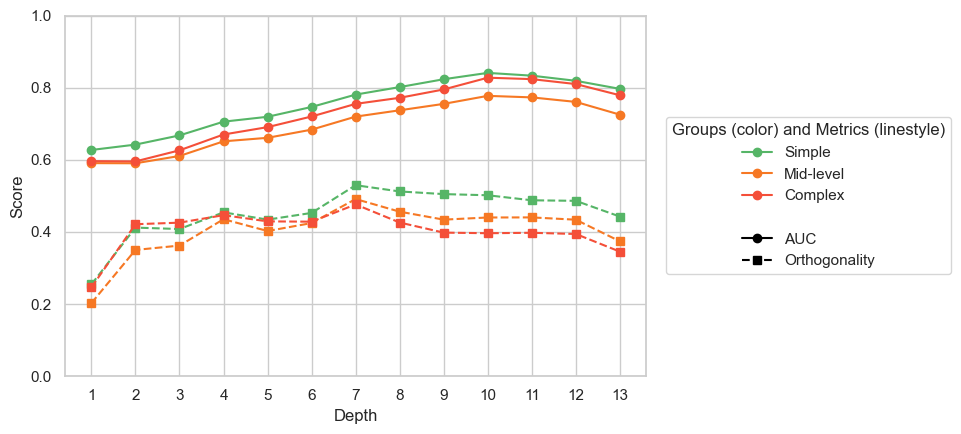

In [ ]:
# from matplotlib.lines import Line2D

# # Fixed plotting order
# group_order = ["Simple", "Mid-level", "Complex"]

# # Pick a mid shade from each palette (index 3 in a 6-color palette)
# category_colors = {
#     "Simple":   sns.color_palette("Greens", 6)[3],
#     "Mid-level":sns.color_palette("Oranges", 6)[3],
#     "Complex":  sns.color_palette("Reds", 6)[3],
# }

# linestyles = {"AUC": "-", "Orthogonality": "--"}
# markers    = {"AUC": "o", "Orthogonality": "s"}

# sns.set_theme(style="whitegrid")
# fig, ax = plt.subplots(figsize=(12, 4.5))

# group_metrics = {}
# for group_name, idxs in group_indices.items():
#     auc_traj = []
#     orth_traj = []
#     for layer in LAYERS:
#         auc_traj.append(_mean_over_indices(auc_vals[layer], idxs))
#         orth_traj.append(_mean_over_indices(uniqueness_vals[layer], idxs))
#     group_metrics[group_name] = {"AUC": auc_traj, "Orthogonality": orth_traj}

# # Plot in fixed order for a tidy legend
# for group_name in group_order:
#     metrics = group_metrics[group_name]
#     color   = category_colors[group_name]

#     ax.plot(
#         LAYERS, metrics["AUC"],
#         color=color, linestyle=linestyles["AUC"], marker=markers["AUC"],
#         label=f"{group_name} (AUC)"
#     )
#     ax.plot(
#         LAYERS, metrics["Orthogonality"],
#         color=color, linestyle=linestyles["Orthogonality"], marker=markers["Orthogonality"],
#         label=f"{group_name} (Orth)"
#     )

# # Axes formatting
# ax.set_xlabel("Depth")
# ax.set_ylabel("Score")
# ax.set_ylim(0, 1)
# ax.set_xticks(np.arange(len(LAYERS)))
# ax.set_xticklabels([i+1 for i in range(len(LAYERS))])

# # Build grouped legend: colored group entries + linestyle key
# group_handles = [
#     Line2D([0], [0], color=category_colors["Simple"],   linestyle=linestyles["AUC"], marker=markers["AUC"], label="Simple"),
#     Line2D([0], [0], color=category_colors["Mid-level"],linestyle=linestyles["AUC"], marker=markers["AUC"], label="Mid-level"),
#     Line2D([0], [0], color=category_colors["Complex"],  linestyle=linestyles["AUC"], marker=markers["AUC"], label="Complex"),
# ]
# style_handles = [
#     Line2D([0], [0], color="black", linestyle=linestyles["AUC"], marker=markers["AUC"], label="AUC"),
#     Line2D([0], [0], color="black", linestyle=linestyles["Orthogonality"], marker=markers["Orthogonality"], label="Orthogonality"),
# ]

# ax.legend(
#     handles=[*group_handles, Line2D([], [], color="none", label=""), *style_handles],
#     title="Groups (color) and Metrics (linestyle)",
#     loc="center left", bbox_to_anchor=(1.02, 0.5),
#     frameon=True
# )

# fig.tight_layout(rect=(0, 0, 0.82, 1))
# os.makedirs("media/auc_orthogonality_over_layers", exist_ok=True)
# plt.savefig("media/auc_orthogonality_over_layers/concept_groups.pdf", format="pdf")
# plt.show()

In [31]:
group_indices = {
    "simple": {
        "hair_color" : [8, 9, 11, 17],               # Black_Hair, Blond_Hair, Brown_Hair, Gray_Hair
        "skin_makeup" : [26, 29, 36],                # Pale_Skin, Rosy_Cheeks, Wearing_Lipstick
        "hair_style" : [4, 5, 32, 33],               # Bald, Bangs, Straight_Hair, Wavy_Hair
        "accessories" : [15, 34, 35, 37, 38],        # Eyeglasses, Earrings, Hat, Necklace, Necktie
        # "artifact" : [10],                         # Blurry
    },
    "mid": {
        "facial_hair" : [0, 16, 22, 30, 24],         # 5_o_Clock_Shadow, Goatee, Mustache, Sideburns, No_Beard
        "eyebrows_eyes" : [1, 12, 23, 3],            # Arched_Eyebrows, Bushy_Eyebrows, Narrow_Eyes, Bags_Under_Eyes
        "mouth_nose" : [6, 7, 21, 27],               # Big_Lips, Big_Nose, Mouth_Slightly_Open, Pointy_Nose
        "face_shape" : [13, 14, 25, 28, 19],         # Chubby, Double_Chin, Oval_Face, Receding_Hairline, High_Cheekbones
    },
    "complex": {
        "demographics" : [20, 39],                   # Male, Young
        "style_aesthetics" : [18, 2, 31],            # Heavy_Makeup, Attractive, Smiling
    }
}

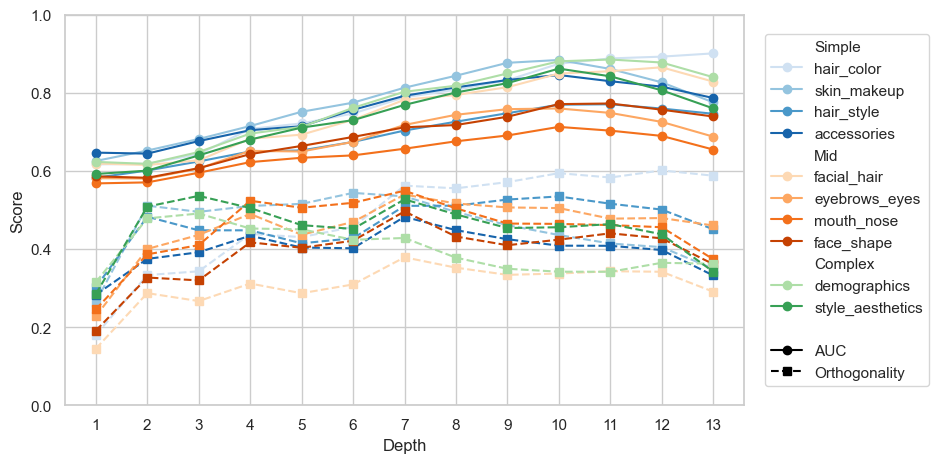

In [35]:
from matplotlib.lines import Line2D

category_to_subgroups = {
    "simple": list(group_indices["simple"].keys()),
    "mid":    list(group_indices["mid"].keys()),
    "complex":list(group_indices["complex"].keys()),
}

# --- 2) Build palettes: one hue per category, different shades for its subgroups ---
category_palettes = {
    "simple":  sns.color_palette("Blues",  n_colors=len(category_to_subgroups["simple"])),
    "mid":     sns.color_palette("Oranges", n_colors=len(category_to_subgroups["mid"])),
    "complex": sns.color_palette("Greens",    n_colors=len(category_to_subgroups["complex"])),
}

# Subgroup → color lookup
subgroup_color = {}
for cat in ["simple", "mid", "complex"]:
    for i, subgroup in enumerate(category_to_subgroups[cat]):
        subgroup_color[(cat, subgroup)] = category_palettes[cat][i]

# --- 3) Compute metrics per *subgroup* (not aggregated over the whole category) ---
subgroup_metrics = {}  # keys: (category, subgroup) -> dict with "AUC" and "Orthogonality" trajectories
for cat, subdict in group_indices.items():
    for subgroup, idxs in subdict.items():
        idxs = np.asarray(idxs, dtype=int)
        auc_traj  = [float(np.asarray(auc_vals[layer])[idxs].mean())          for layer in LAYERS]
        orth_traj = [float(np.asarray(uniqueness_vals[layer])[idxs].mean())   for layer in LAYERS]
        subgroup_metrics[(cat, subgroup)] = {"AUC": auc_traj, "Orthogonality": orth_traj}

# --- 4) Plot: same axes, two linestyles, color by category hue / subgroup shade ---
sns.set_theme(style="whitegrid")
linestyles = {"AUC": "-", "Orthogonality": "--"}
markers     = {"AUC": "o", "Orthogonality": "s"}

fig, ax = plt.subplots(figsize=(12, 4.8))

# Plot in category order, then subgroup order (so legend looks tidy)
for cat in ["simple", "mid", "complex"]:
    for subgroup in category_to_subgroups[cat]:
        color = subgroup_color[(cat, subgroup)]
        m = subgroup_metrics[(cat, subgroup)]

        ax.plot(
            LAYERS, m["AUC"],
            color=color, linestyle=linestyles["AUC"], marker=markers["AUC"],
            label=f"{subgroup} (AUC)"
        )
        ax.plot(
            LAYERS, m["Orthogonality"],
            color=color, linestyle=linestyles["Orthogonality"], marker=markers["Orthogonality"],
            label=f"{subgroup} (Orth)"
        )

# --- 5) Axes formatting ---
ax.set_xlabel("Depth")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(len(LAYERS)))
ax.set_xticklabels([i+1 for i in range(len(LAYERS))])

# --- 6) Build a grouped legend: category headers + subgroup entries + linestyle key ---
# Header handles (invisible lines used as headings)
header_handles = [
    Line2D([0], [0], color="none", label="Simple",  linewidth=0),
    Line2D([0], [0], color="none", label="Mid",     linewidth=0),
    Line2D([0], [0], color="none", label="Complex", linewidth=0),
]

# Subgroup handles (colored) — just one handle per subgroup (AUC style)
subgroup_handles = []
for cat in ["simple", "mid", "complex"]:
    # add a header marker, then the subgroups
    subgroup_handles.append(Line2D([], [], color="none", label=cat.capitalize()))
    for subgroup in category_to_subgroups[cat]:
        color = subgroup_color[(cat, subgroup)]
        subgroup_handles.append(
            Line2D([0], [0], color=color, linestyle=linestyles["AUC"], marker=markers["AUC"], label=subgroup)
        )

# Linestyle key (monochrome) to explain AUC vs Orthogonality
style_handles = [
    Line2D([0], [0], color="black", linestyle=linestyles["AUC"], marker=markers["AUC"], label="AUC"),
    Line2D([0], [0], color="black", linestyle=linestyles["Orthogonality"], marker=markers["Orthogonality"], label="Orthogonality"),
]

# Compose final legend handles (category headers + subgroups + style key)
# (We already added a text header before each category's subgroups above.)
legend_handles = subgroup_handles + [Line2D([], [], color="none", label=""), *style_handles]

ax.legend(
    handles=legend_handles,
    #title="Groups (color) and Metrics (linestyle)",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

fig.tight_layout(rect=(0, 0, 0.80, 1))

os.makedirs("media/auc_orthogonality_over_layers", exist_ok=True)
plt.savefig("media/auc_orthogonality_over_layers/concept_groups2.pdf", format="pdf")
plt.show()